# Time stability

In [1]:
include("smij-functions.jl");

## p25: stability regions for ODE formulas

In [2]:
using Polynomials
function ABregion(order)
    ρ = Polynomial([zeros(order-1);-1;1])
    σ = Polynomial( ([1], [-1,3]/2, [5,-16,23]/12)[order] )
    z = cis.(2π*(0:360)/360)
    return @. ρ(z) / σ(z)
end

function AMregion(order)
    ρ = Polynomial([zeros(order-2);-1;1])
    s = ([], [], [-1,8,5]/12, [1,-5,19,9]/24, 
            [-19,106,-264,646,251]/720, [3/160,-173/1440,241/720,-133/240,1427/1440,95/288])
    σ = Polynomial( s[order] )
    z = cis.(2π*(0:360)/360)
    return @. ρ(z) / σ(z)
end

function BDregion(order)
    z = cis.(2π*(0:360)/360)
    d = @. 1 - 1/z
    p = Polynomial([0; 1 ./ (1:order)])
    return p.(d)
end

function RKregion(order)
    T0 = Polynomial([1/factorial(k) for k in 0:order])
    T1 = Polynomial([1/factorial(k) for k in 0:order-1])
    z = cis.(2π*(0:360)/360)
    W = fill(complex(0.0),360)
    w = 0;
    for (k,z) in enumerate(z[2:end])
        w -= (T0(w) - z^order) / T1(w)
        W[k] = w
    end
    return W
end;

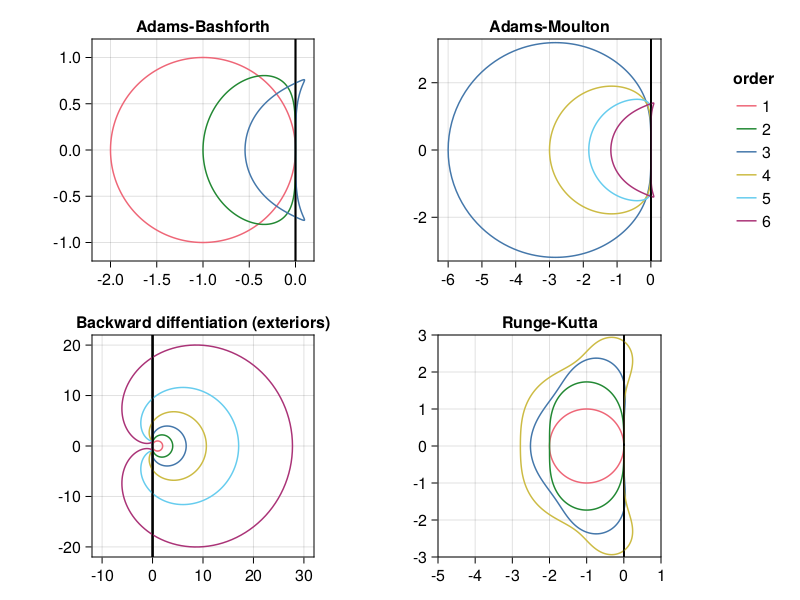

In [3]:
using CairoMakie
using Makie.ColorSchemes

colors = ColorSchemes.tol_bright[1:6]

data = [
    (ABregion, 1:3, [-2.2,0.2,-1.2,1.2], "Adams-Bashforth"),
    (AMregion, 3:6, [-6.3,0.3,-3.3,3.3], "Adams-Moulton"),
    (BDregion, 1:6, [-12,32,-22,22], "Backward diffentiation (exteriors)"),
    (RKregion, 1:4, [-5,1,-3,3], "Runge-Kutta")
]

fig = Figure()
ax = vec([Axis(fig[j,i], aspect=DataAspect()) for i in 1:2, j in 1:2])
for (ax,(kind,orders,limits,title)) in zip(ax,data)
    for order in orders
        w = kind(order)
        lines!(ax,real(w),imag(w), label="$order", color=colors[order])
        limits!(ax,limits...)
        ax.title = title
        vlines!(ax,0, color=:black)
    end
end

Legend(fig[1,3], ax[3], "order", framevisible=false)
fig

## p26: eigenvalues of 2nd-order Chebyshev diff. matrix

In [4]:
N = 60
D, x = cheb(N)
D² = (D^2)[2:N, 2:N]
λ, V = eigen(D², sortby=(-)∘real)

xx = -1:0.01:1
vN4 = [0; V[:,N ÷ 4 - 1]; 0]
vvN4 = polyinterp(x, vN4).(xx)
vN = [0; V[:, N-1]; 0];

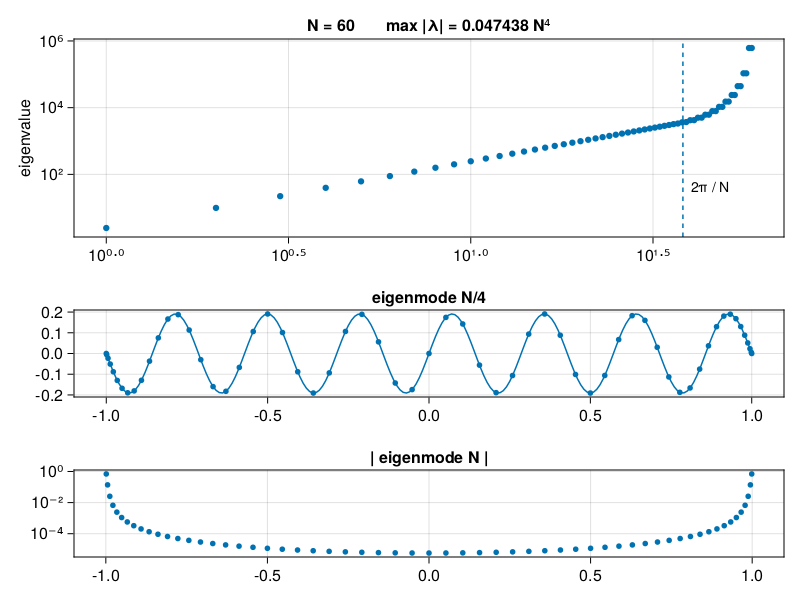

In [5]:
using PyFormattedStrings
# Plot eigenvalues:
fig = Figure()
M = maximum(-λ)/N^4
ax = Axis(fig[1:2,1], 
    xscale=log10, yscale=log10, ylabel="eigenvalue",
    title=f"N = {N}       max |λ| = {M:.6f} N⁴" )
    
scatter!(-λ, markersize=9)
vlines!(ax, 2N / π, linestyle=:dash)
text!(2.1N / π, 24, text="2π / N", textsize=14)

# Plot eigenmodes N/4 (physical) and N (nonphysical):
ax = Axis(fig[3,1], title="eigenmode N/4")
lines!(xx, vvN4)
scatter!(x, vN4, markersize=8)

ax = Axis(fig[4,1], title="| eigenmode N |", yscale=log10)
scatter!(x[2:N], abs.(vN[2:N]), markersize=8)
fig

## p27: Solve KdV eq. 

$$u_t + uu_x + u_{xxx} = 0, \quad  x \in [-\pi,\pi]$$

In [6]:
# Set up grid and two-soliton initial data:
N = 256
dt = 0.4 / N^2
x = (2π / N) * (-N/2 : N/2-1)
A,B = 25,16
u = @. 3A^2 * sech(0.5 * (A * (x + 2)))^2 + 3B^2 * sech(0.5 * (B * (x + 1)))^2
û = fft(u)
k = [0:N/2-1; 0; -N/2+1:-1]
ik3 = 1im * k .^ 3

# Solve PDE and plot results:
tmax = 0.006
nsteps = round(Int, tmax / dt)
dt = tmax / nsteps
t = dt*(0:nsteps)
U = zeros(N,nsteps+1)
U[:,1] .= u
for n = 1:nsteps
    g = -0.5im * dt * k
    E = exp.(dt * ik3 / 2)
    E2 = E .^ 2
    a = g .* fft(real(ifft(û)) .^ 2)
    b = g .* fft(real(ifft(E .* (û + a / 2))) .^ 2)     # 4th-order
    c = g .* fft(real(ifft(E .* û + b / 2)) .^ 2)     # Runge-Kutta
    d = g .* fft(real(ifft(E2 .* û + E .* c)) .^ 2)
    û = E2 .* û + (E2 .* a + 2 * E .* (b + c) + d) / 6
    
    U[:,n+1] = real(ifft(û))
    
end

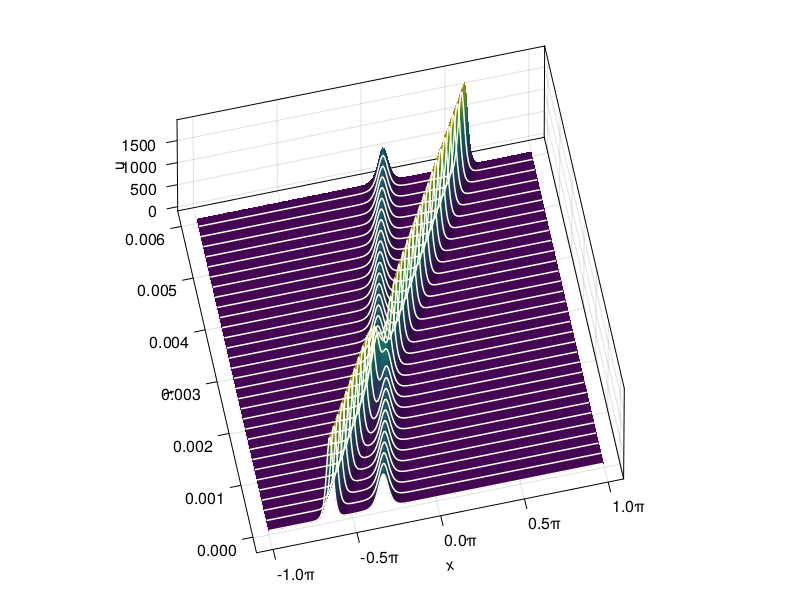

In [7]:
fig = Figure()
Axis3(fig[1, 1],
    xticks = MultiplesTicks(5, π, "π"),
    xlabel="x", ylabel="t", zlabel="u", 
    azimuth=4.5, elevation=1.2,
)
gap = max(1,round(Int, 2e-4/(t[2]-t[1])) - 1)
surface!(x, t, U)
[ lines!(x, fill(t[j], length(x)), U[:, j].+.01, color=:ivory) for j in 1:gap:size(U,2) ]
fig

In [8]:
fig = Figure(size=(480,320))
index = Observable(1)
ax = Axis(fig[1, 1],
    xticks = MultiplesTicks(5, π, "π"),
    xlabel="x", ylabel="u"
)
lines!(x, @lift(U[:,$index]))
record(fig, "_build/html/p27.mp4", 1:4:size(U,2)) do i
    index[] = i
    ax.title = f"t = {t[i]:.5f}"
end;

<video autoplay controls><source src="p27.mp4" type="video/mp4"></video>